In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, classification_report,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv(r"C:\Users\dell\OneDrive\Desktop\bank churn\resources\analytical_base_table.csv")  # replace with actual data path
X = df.drop(columns=['Exited'])
y = df['Exited']

# Split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Define columns
scale_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']


In [3]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), scale_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])


In [4]:
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    # ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(solver='liblinear', max_iter=500))
])

param_grid = {
    'model__C': [0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__class_weight': [None, 'balanced']
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l1'}


In [5]:
grid.best_score_

0.7553698791629826

In [6]:
probs_val = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, probs_val)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid div-by-zero
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"Optimal Threshold (F1 max): {best_thresh:.4f}")


Optimal Threshold (F1 max): 0.5741


In [7]:
# Find threshold with recall >= 0.70 and highest possible precision
recall_cutoff = 0.75
valid_idxs = np.where(recall >= recall_cutoff)[0]

# Of those, pick the one with highest precision
best_idx_recall = valid_idxs[np.argmax(precision[valid_idxs])]
best_thresh_recall = thresholds[best_idx_recall]

print(f"Threshold for Recall ≥ 75%: {best_thresh_recall:.4f}")


Threshold for Recall ≥ 75%: 0.4908


In [8]:
probs_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test_recall = (probs_test >= best_thresh_recall).astype(int)

print(f"ROC-AUC on Test: {roc_auc_score(y_test, probs_test):.4f}")
print(classification_report(y_test, y_pred_test_recall))

ROC-AUC on Test: 0.8377
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      1593
           1       0.44      0.77      0.56       407

    accuracy                           0.75      2000
   macro avg       0.68      0.76      0.69      2000
weighted avg       0.83      0.75      0.77      2000



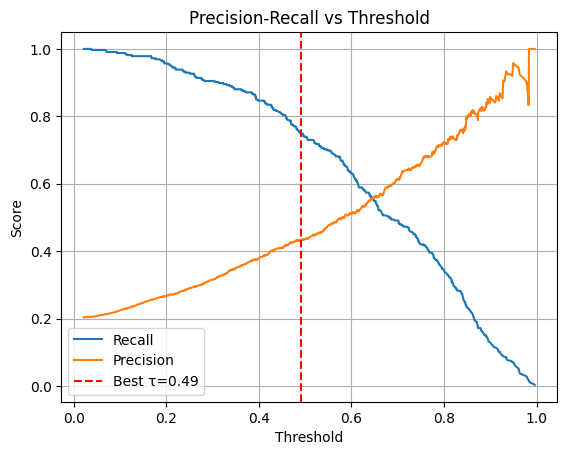

In [9]:
import matplotlib.pyplot as plt

plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, precision[:-1], label='Precision')

plt.axvline(x=best_thresh_recall, color='red', linestyle='--', label=f'Best τ={best_thresh_recall:.2f}')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()


In [10]:
probs_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test = (probs_test >= best_thresh).astype(int)

print(f"ROC-AUC on Test: {roc_auc_score(y_test, probs_test):.4f}")
print(classification_report(y_test, y_pred_test))


ROC-AUC on Test: 0.8377
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1593
           1       0.50      0.68      0.57       407

    accuracy                           0.80      2000
   macro avg       0.70      0.75      0.72      2000
weighted avg       0.83      0.80      0.81      2000



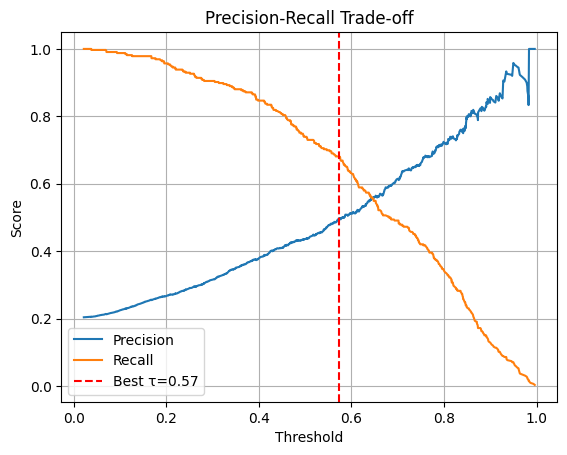

In [11]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Best τ={best_thresh:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Trade-off")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
probs_test

array([0.17141472, 0.30954428, 0.17785526, ..., 0.90290856, 0.20096073,
       0.42197913])

In [13]:
#choosing best thres recall as recall is more important than precision


In [14]:
from joblib import dump

model_package = {
    'model':best_model,
    'threshold':best_thresh_recall
}
dump(model_package,'../models/log_model.pkl')

['../models/log_model.pkl']

In [15]:
def lr():
    return best_thresh

In [16]:
lr()

0.5740640811647464

In [17]:
# Extract the fitted logistic regression model from the pipeline
logreg_model = best_model.named_steps['model']

# Coefficients (one per feature)
print("Coefficients:", logreg_model.coef_)

# Intercept term
print("Intercept:", logreg_model.intercept_)


Coefficients: [[-0.04025232  0.74328687 -0.02080193  0.02507161  0.05828634  0.
   0.81877059  0.          0.11737024 -0.394665    0.         -0.10732177
   0.6581819  -0.24354006 -0.03076172 -1.49855924  2.10947     1.54809714]]
Intercept: [0.]


In [18]:
# If using ColumnTransformer inside preprocessor
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Combine with coefficient values
import pandas as pd

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logreg_model.coef_[0]  # [0] since binary classification
})

# Sort by absolute value
coeff_df['abs_coef'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='abs_coef', ascending=False).drop('abs_coef', axis=1)

print(coeff_df)


                   Feature  Coefficient
16    cat__NumOfProducts_3     2.109470
17    cat__NumOfProducts_4     1.548097
15    cat__NumOfProducts_2    -1.498559
6   cat__Geography_Germany     0.818771
1                 num__Age     0.743287
12   cat__IsActiveMember_0     0.658182
9         cat__Gender_Male    -0.394665
13   cat__IsActiveMember_1    -0.243540
8       cat__Gender_Female     0.117370
11        cat__HasCrCard_1    -0.107322
4     num__EstimatedSalary     0.058286
0         num__CreditScore    -0.040252
14    cat__NumOfProducts_1    -0.030762
3             num__Balance     0.025072
2              num__Tenure    -0.020802
7     cat__Geography_Spain     0.000000
5    cat__Geography_France     0.000000
10        cat__HasCrCard_0     0.000000


| Coefficient          | What it Means                                                                                                        |
| -------------------- | -------------------------------------------------------------------------------------------------------------------- |
| **Positive (β > 0)** | That feature **increases the log-odds of churn** → pushes customer **towards churning**                              |
| **Negative (β < 0)** | That feature **decreases the log-odds of churn** → pushes customer **away from churning** (i.e. more likely to stay) |


| Feature                  | Coefficient | Interpretation                                        |
| ------------------------ | ----------- | ----------------------------------------------------- |
| `cat__NumOfProducts_3`   | **+2.11**   | Having 3 products is **strongly linked** to churn.    |
| `cat__NumOfProducts_4`   | +1.55       | 4 products = high churn risk.                         |
| `cat__NumOfProducts_2`   | **-1.50**   | 2 products **protects** against churn.                |
| `cat__Geography_Germany` | +0.82       | German customers churn more than French/Spanish.      |
| `num__Age`               | +0.74       | Older customers are **more likely** to churn.         |
| `cat__IsActiveMember_0`  | +0.66       | **Inactive customers** are much more likely to churn. |
| `cat__Gender_Male`       | -0.39       | Males slightly **less likely** to churn.              |
| `cat__IsActiveMember_1`  | -0.24       | Active members are less likely to churn.              |
| `num__CreditScore`       | -0.04       | Better credit → slight churn reduction.               |
